# Tensorflow Example with Images of Classified Flowers 
---
#### - Chanmge the path of `dataset_url` to local images after downloading in section 2, starting with `import ssl`
#### - Click on `Run All` to see `tensorflow` in action for image classifiation using deep learning
#### - Comments in between will let you know what is going on at a high level (we will have to understand at a detailed level for the end presentation to explain it)

In [3]:
# Import TensorFlow and other necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [4]:
import ssl
import requests
requests.packages.urllib3.disable_warnings()

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dataset_url = "/Users/pjwl/.keras/datasets/"

data_dir = tf.keras.utils.get_file(
    'flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

# dataset_url = "data/training/"
data_dir = pathlib.Path(dataset_url)


228813984/228813984 [==============================] - 21s 0us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


3670


In [29]:
# Image Loader Params
batch_size = 32
img_height = 180 # for people - 120
img_width = 180 # for people - 128

print(data_dir)

# Train Split at 80%
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Validation of the data at 80%
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


/Users/pjwl/.keras/datasets/flower_photos
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


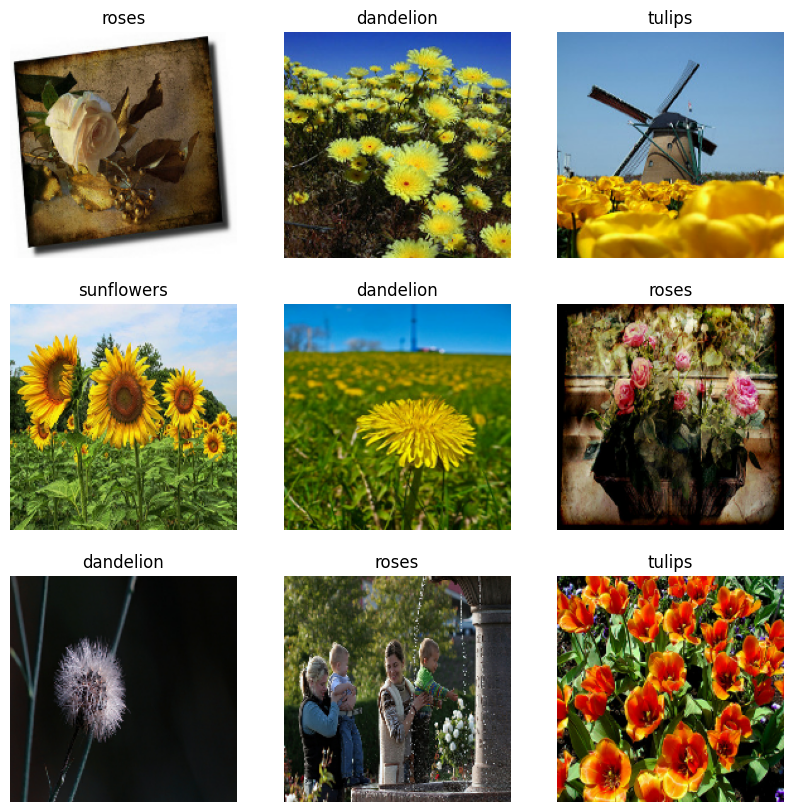

In [7]:
# Classification of names - each image type in its own dir
class_names = train_ds.class_names
print(class_names)

# Visualize the images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [8]:
# Fitting to Model
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

# The image_batch is a tensor of the shape(32, 180, 180, 3). 
# This is a batch of 32 images of shape 180x180x3(the last dimension refers to color channels RGB). 
# The label_batch is a tensor of the shape(32,), these are corresponding labels to the 32 images.

# You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.


(32, 180, 180, 3)
(32,)


# Configure the dataset for performance
---
#### Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

  #### - `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

  #### - `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Standardize the data
---
#### The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

#### Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [10]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.9990197


In [11]:
# Create basic Keras Model

# The Keras Sequential model consists of three convolution blocks(tf.keras.layers.Conv2D) 
# with a max pooling layer(tf.keras.layers.MaxPooling2D) in each of them. 
# 
# There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that 
# is activated by a ReLU activation function ('relu'). 
# 
# This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

# Compile the model

# For this tutorial, choose the tf.keras.optimizers.Adam optimizer and 
# tf.keras.losses.SparseCategoricalCrossentropy loss function. 
# 
# To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

# Show the Model Summary - need to look into what this means
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [12]:
# Train the Sequential Keras Model (this will run in epochs - look this up too)

# Will take about 5 minutes or so for all 10 epochs to complete, depending on machine
# performance and resource availability

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10
92/92 [==============================] - 30s 315ms/step - loss: 1.3886 - accuracy: 0.4104 - val_loss: 1.1160 - val_accuracy: 0.5177
Epoch 2/10
92/92 [==============================] - 28s 303ms/step - loss: 1.0288 - accuracy: 0.5872 - val_loss: 0.9538 - val_accuracy: 0.6076
Epoch 3/10
92/92 [==============================] - 27s 299ms/step - loss: 0.8365 - accuracy: 0.6778 - val_loss: 0.9806 - val_accuracy: 0.6022
Epoch 4/10
92/92 [==============================] - 27s 294ms/step - loss: 0.6263 - accuracy: 0.7752 - val_loss: 0.9139 - val_accuracy: 0.6267
Epoch 5/10
92/92 [==============================] - 27s 293ms/step - loss: 0.3791 - accuracy: 0.8685 - val_loss: 0.9972 - val_accuracy: 0.6635
Epoch 6/10
92/92 [==============================] - 27s 292ms/step - loss: 0.1873 - accuracy: 0.9346 - val_loss: 1.2128 - val_accuracy: 0.6512
Epoch 7/10
92/92 [==============================] - 27s 290ms/step - loss: 0.1055 - accuracy: 0.9710 - val_loss: 1.3501 - val_accuracy: 0.6362

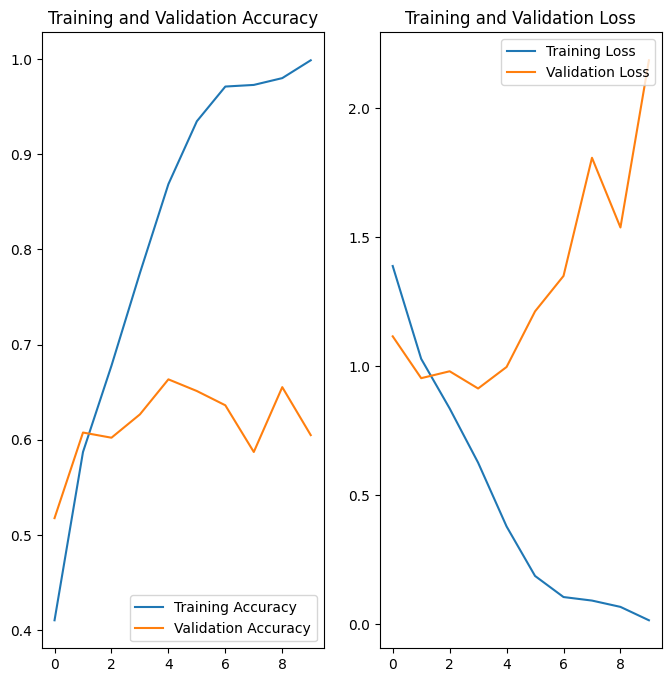

In [13]:
# Visualize the Training Results in Plot Forms

def visualization_report(history, epochs=10):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()


visualization_report(history, epochs)


#### The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

#### The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

# Overfitting
---
#### In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.


#### When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.


#### There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add dropout to your model.

# Data augmentation
---
#### Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

#### You will implement data augmentation using the following Keras preprocessing layers:`tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

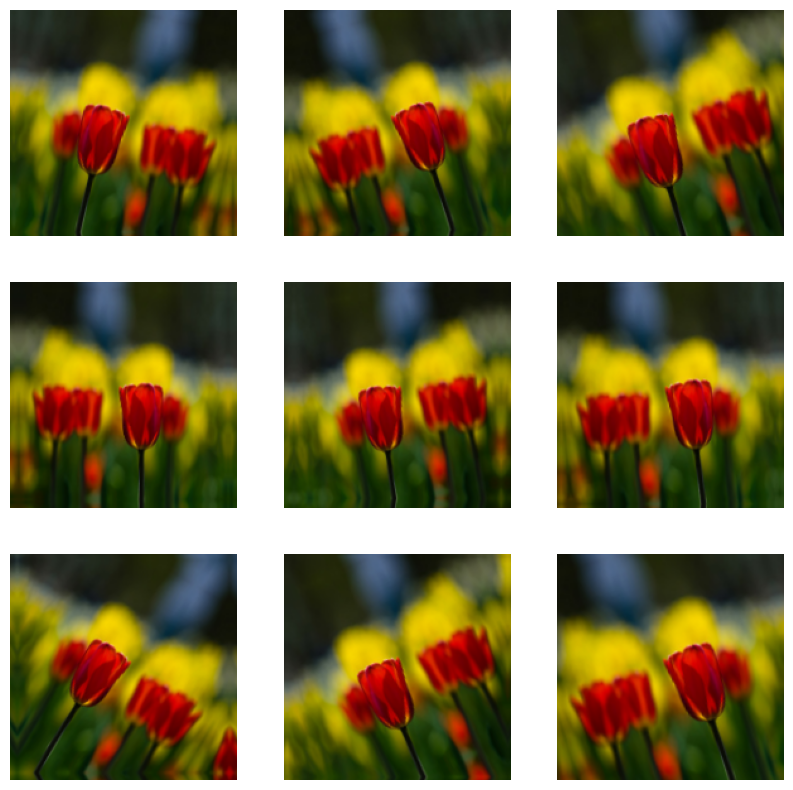

In [14]:
# Creating artifical data as well

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

# Visualize a few augmented examples by applying data augmentation to the same image several times:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [15]:
# Recompile and train the model after overfitting handling

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

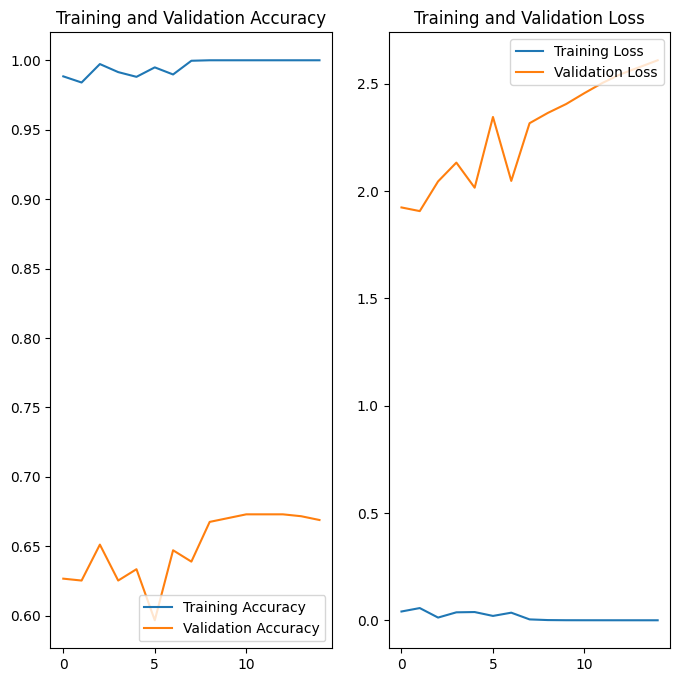

In [16]:
# Visualiation Report of the newly trained:
visualization_report(history, epochs)


# Predict on New Data
---
#### Use your model to classify an image that wasn't included in the training or validation sets.

In [27]:
# sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
sunflower_path = "data/predictions/Red_sunflower"
rose_path = "data/predictions/rose.jpeg"
tulip_path = "data/predictions/tulips.jpeg"

paths = [sunflower_path, rose_path, tulip_path]

for p in paths:
    img = tf.keras.utils.load_img(
        p, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )


1/1 [==============================] - 0s 28ms/step
This image most likely belongs to sunflowers with a 82.75 percent confidence.
1/1 [==============================] - 0s 27ms/step
This image most likely belongs to roses with a 95.39 percent confidence.
1/1 [==============================] - 0s 37ms/step
This image most likely belongs to tulips with a 100.00 percent confidence.
